In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm as tqdm_notebook
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
np.seterr(divide='ignore', invalid='ignore')
from sklearn.metrics import precision_recall_fscore_support as score

In [228]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [229]:
X_train = X_train.reshape(X_train.shape[0],784, 1)
X_test = X_test.reshape(X_test.shape[0],784, 1)

In [230]:
X_train=X_train/255
X_test= X_test/255

In [231]:
X_train.shape

(60000, 784, 1)

In [259]:
def Average(lst):
    return sum([lst]) / len([lst])

In [260]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs,activation_function = 'sigmoid', hidden_sizes=[1],leaky_slope = 0.1):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    # self.params_h = []
    self.leaky_slope = leaky_slope
    self.activation_function = activation_function
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    


  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
  
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
      
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_activation(self.H[k-1])) 
    # print(list(self.dW.values())[-1],"Final Weight")/
    


  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                       
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
      # print(self.W)
      weight_list = list(self.W.values())
      bias_list = list(self.B.values())
      avg_weights = Average(weight_list[-1])
      print(avg_weights)
      
      print("Weights for activation function:",self.activation_function)
      print("Value of Weights at output layer for epoch",epoch,":",weight_list[-1])
      print("Value of bias at output layer for epoch",epoch,":",bias_list[-1])

      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
        print("Loss for epoch",epoch,":",loss[epoch])
        print('\n--\n')
    
    if display_loss:
      plt.title(self.activation_function)
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()



In [234]:
X_train.shape

(60000, 784, 1)

In [235]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(60000, 10) (10000, 10)


In [ ]:
def post_process(model):
  Y_pred_train = model.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train,1)

  Y_pred_val = model.predict(X_test)
  Y_pred_val = np.argmax(Y_pred_val,1)
  # print(Y_pred_val)
  Test_loss = model.cross_entropy(y_test, Y_pred_val)

  accuracy_train = accuracy_score(Y_pred_train, y_train)
  accuracy_val = accuracy_score(Y_pred_val, y_test)
  

  set(y_test) - set(Y_pred_val)
  precision, recall, f1score, support = score(y_test, Y_pred_val)


  print("These values are never predicted:",set(y_test) - set(Y_pred_val))
  print('\n--\n')
  print("precision",precision)
  print('\n--\n')
  print("recall", recall)
  print('\n--\n')
  print("f1score",f1score)
  print('\n--\n')
  print("support",support)
  print('\n--\n')
  print("Test_loss",round(Test_loss, 4))
  print('\n--\n')
  print("Training accuracy", round(accuracy_train, 4))
  print('\n--\n')
  print("Validation accuracy", round(accuracy_val, 4))

sigmoid


[[-0.89454322  0.27709226  0.19076687 -0.64405219  0.98390709  1.51849229
  -0.18362239 -0.27265523 -0.84150639 -1.11711149]]
Weights for activation function: sigmoid
Value of Weights at output layer for epoch 0 : [[-0.89454322  0.27709226  0.19076687 -0.64405219  0.98390709  1.51849229
  -0.18362239 -0.27265523 -0.84150639 -1.11711149]]
Value of bias at output layer for epoch 0 : [[ 0.00288831  0.00077645  0.00013021  0.00272052 -0.00475029 -0.01110142
   0.00135786  0.0020383   0.00270906  0.003231  ]]
Loss for epoch 0 : 2.4767216439685207

--

[[-0.89045358  0.28001149  0.19221519 -0.6401736   0.97719278  1.50929673
  -0.18139007 -0.27342361 -0.83946863 -1.11703912]]
Weights for activation function: sigmoid
Value of Weights at output layer for epoch 1 : [[-0.89045358  0.28001149  0.19221519 -0.6401736   0.97719278  1.50929673
  -0.18139007 -0.27342361 -0.83946863 -1.11703912]]
Value of bias at output layer for epoch 1 : [[ 0.00572876  0.00150135  0.00022138  0.00539092 -0.00942423 -

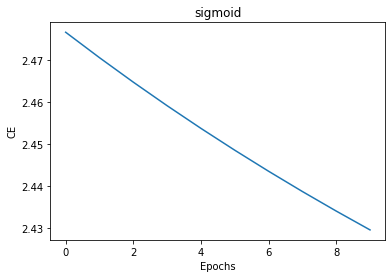

These values are never predicted: {0, 8, 2, 6}

--

precision [0.         0.0440678  0.         0.06882591 0.09090909 0.09775155
 0.         0.14864865 0.         0.21996997]

--

recall [0.         0.02290749 0.         0.01683168 0.01425662 0.68721973
 0.         0.01070039 0.         0.58077304]

--

f1score [0.         0.03014493 0.         0.02704853 0.02464789 0.17115734
 0.         0.0199637  0.         0.31908522]

--

support [ 980 1135 1032 1010  982  892  958 1028  974 1009]

--

Test_loss -3.0614

--

Training accuracy 0.1296

--

Validation accuracy 0.1267

--

relu


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[-0.49549516 -0.41476863  0.67097337 -0.91488258 -1.79538731 -0.6719062
  -0.51873644  0.74162756 -1.28368221  0.67553747]]
Weights for activation function: relu
Value of Weights at output layer for epoch 0 : [[-0.49549516 -0.41476863  0.67097337 -0.91488258 -1.79538731 -0.6719062
  -0.51873644  0.74162756 -1.28368221  0.67553747]]
Value of bias at output layer for epoch 0 : [[ 0.00601736  0.00701355  0.00458208  0.00636695  0.00608997  0.00541603
   0.00601883 -0.05213845  0.0060574   0.00457628]]
Loss for epoch 0 : 6.7923412077477625

--

[[-0.44705818 -0.41290243  0.61319685 -0.88190947 -1.74970329 -0.63311922
  -0.46193069  0.60677444 -1.2581427   0.61807457]]
Weights for activation function: relu
Value of Weights at output layer for epoch 1 : [[-0.44705818 -0.41290243  0.61319685 -0.88190947 -1.74970329 -0.63311922
  -0.46193069  0.60677444 -1.2581427   0.61807457]]
Value of bias at output layer for epoch 1 : [[ 0.01070446  0.0126817  -0.0039409   0.01152102  0.01105024  0.009567

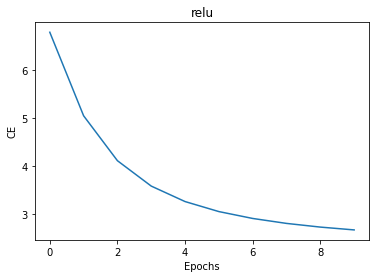

These values are never predicted: {0, 3, 4, 5, 8}

--

precision [0.         0.15120643 0.07317073 0.         0.         0.
 0.         0.22562814 0.         0.11283186]

--

recall [0.         0.9938326  0.00581395 0.         0.         0.
 0.         0.43677043 0.         0.05054509]

--

f1score [0.         0.26247818 0.01077199 0.         0.         0.
 0.         0.29754805 0.         0.0698152 ]

--

support [ 980 1135 1032 1010  982  892  958 1028  974 1009]

--

Test_loss -1.8942

--

Training accuracy 0.1609

--

Validation accuracy 0.1634

--

tanh


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0.3534972  -1.10027755  0.02456033 -0.07026035 -1.83860316  2.35566295
   0.0321925   0.22503733 -1.34012057 -0.45843547]]
Weights for activation function: tanh
Value of Weights at output layer for epoch 0 : [[ 0.3534972  -1.10027755  0.02456033 -0.07026035 -1.83860316  2.35566295
   0.0321925   0.22503733 -1.34012057 -0.45843547]]
Value of bias at output layer for epoch 0 : [[ 0.00258196  0.0024128   0.0030657   0.00333362 -0.00354694 -0.01717777
   0.00300877  0.00323736  0.00012884  0.00295565]]
Loss for epoch 0 : 2.82522511774071

--

[[ 0.35630051 -1.10286598  0.02685291 -0.07426975 -1.82567212  2.33285066
   0.03387533  0.22553404 -1.33479782 -0.45455456]]
Weights for activation function: tanh
Value of Weights at output layer for epoch 1 : [[ 0.35630051 -1.10286598  0.02685291 -0.07426975 -1.82567212  2.33285066
   0.03387533  0.22553404 -1.33479782 -0.45455456]]
Value of bias at output layer for epoch 1 : [[ 0.00507754  0.00473404  0.00605832  0.00659802 -0.00704933 -0.033815

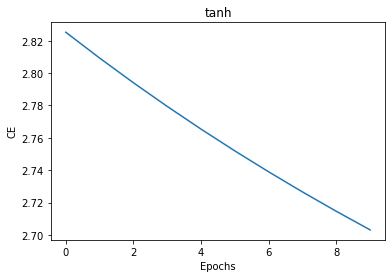

These values are never predicted: {8, 9, 2, 6}

--

precision [0.05555556 0.175      0.         0.         0.06513845 0.07396611
 0.         0.0952381  0.         0.        ]

--

recall [0.00204082 0.0061674  0.         0.         0.29226069 0.45515695
 0.         0.00194553 0.         0.        ]

--

f1score [0.00393701 0.01191489 0.         0.         0.10653304 0.12725278
 0.         0.00381316 0.         0.        ]

--

support [ 980 1135 1032 1010  982  892  958 1028  974 1009]

--

Test_loss -2.8924

--

Training accuracy 0.0664

--

Validation accuracy 0.0704

--

leaky_relu


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[-1.31851732  1.69639732  1.39200924 -0.58314299  1.29754197  1.31505627
  -0.22028379  0.208602   -0.60128347  0.53887917]]
Weights for activation function: leaky_relu
Value of Weights at output layer for epoch 0 : [[-1.31851732  1.69639732  1.39200924 -0.58314299  1.29754197  1.31505627
  -0.22028379  0.208602   -0.60128347  0.53887917]]
Value of bias at output layer for epoch 0 : [[ 0.00682784  0.00594945  0.0064712   0.00722381 -0.06061593  0.00586506
   0.0069821   0.00743321  0.00686435  0.0069989 ]]
Loss for epoch 0 : 11.1954351664775

--

[[-1.24055404  1.25068505  1.43934683 -0.52250442  1.32715557  1.34972573
  -0.12892888  0.22922007 -0.54143972  0.56255221]]
Weights for activation function: leaky_relu
Value of Weights at output layer for epoch 1 : [[-1.24055404  1.25068505  1.43934683 -0.52250442  1.32715557  1.34972573
  -0.12892888  0.22922007 -0.54143972  0.56255221]]
Value of bias at output layer for epoch 1 : [[ 0.01204879 -0.03515325  0.00751333  0.01323104 -0.057515

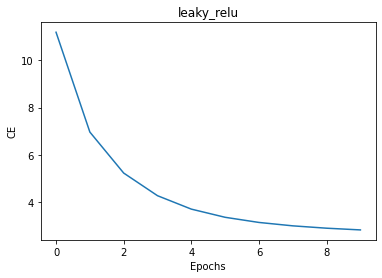

These values are never predicted: {8, 4, 6}

--

precision [0.10370983 0.19036697 0.11632454 0.125      0.         0.08783784
 0.         0.02654867 0.         0.05405405]

--

recall [0.76734694 0.21938326 0.11531008 0.01485149 0.         0.01457399
 0.         0.00291829 0.         0.00198216]

--

f1score [0.18272385 0.20384773 0.11581509 0.02654867 0.         0.025
 0.         0.00525855 0.         0.00382409]

--

support [ 980 1135 1032 1010  982  892  958 1028  974 1009]

--

Test_loss -1.6702

--

Training accuracy 0.1175

--

Validation accuracy 0.1153

--



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [264]:
for activation_function in ["sigmoid","relu","tanh","leaky_relu"]:
  print(activation_function)
  model = FFSN_MultiClass(784,10,activation_function)
  model.fit(X_train,y_OH_train,epochs=10,learning_rate=.001,display_loss=True)
  post_process(model)
  print('\n--\n')